In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings

warnings.filterwarnings('ignore')

def lstm_sliding_window_prediction(area: str):
    # 1. 創建模擬時間序列數據
    data = pd.read_csv(r"data\owid-covid-data.csv")

    # 選擇某一地區的數據進行分析，例如 "World"
    region_data = data[data['iso_code'] == area]
    region_data['new_cases'] = region_data['new_cases'].fillna(0)  # 填充缺失值

    # 可視化原始數據
    # plt.figure(figsize=(20, 6))
    # plt.plot(region_data['date'], region_data['new_cases'])
    # plt.title('Daily New COVID Cases (World)')
    # plt.xlabel('Date')
    # plt.ylabel('New Cases')
    # plt.xticks(rotation=45)
    # plt.show()

    # 2. 數據預處理
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(region_data['new_cases'].values.reshape(-1, 1))

    # 使用移動窗格創建時間序列數據集
    def create_sliding_window_dataset(data, window_size=10):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i + window_size, 0])
            y.append(data[i + window_size, 0])
        return np.array(X), np.array(y)

    # 定義窗口大小
    window_size = 28

    # 創建滑動窗口數據集
    X, y = create_sliding_window_dataset(scaled_data, window_size)

    # 重塑 X 為 LSTM 的輸入格式 (樣本數, 時間步長, 特徵數)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # 分割為訓練集和測試集
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # 3. 構建 LSTM 模型
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)  # 單一輸出值
    ])

    # 編譯模型
    model.compile(optimizer='adam', loss='mean_absolute_error')

    # 4. 訓練模型
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # 5. 預測並還原預測結果
    predicted_cases = model.predict(X_test)
    predicted_cases = scaler.inverse_transform(predicted_cases)  # 還原縮放

    # 還原測試集實際值
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # 6. 視覺化結果
    plt.figure(figsize=(20, 6))
    plt.plot(region_data['date'][-len(y_test_actual):], y_test_actual, color='blue', label='Actual Cases')
    plt.plot(region_data['date'][-len(predicted_cases):], predicted_cases, color='red', label='Predicted Cases')
    plt.title('Sliding Window Prediction (New COVID Cases)')
    plt.xlabel('Date')
    plt.ylabel('New Cases')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    # 7. 評估模型
    from sklearn.metrics import mean_absolute_error, root_mean_squared_error
    print(f'MAE: {mean_absolute_error(y_test_actual, predicted_cases)}')
    print(f'MAE / Mean: {mean_absolute_error(y_test_actual, predicted_cases) / np.mean(y_test_actual)}')
    print(f'RMSE: {root_mean_squared_error(y_test_actual, predicted_cases)}')


In [43]:
regions = [
    "ARG",
    "MEX",
    "THA",
    "TWN",
    "CHN",
    "OWID_ASI",
    "OWID_NAM",
    "MAC",
    "KOR",
    "OWID_UMC"
]

Region: ARG
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


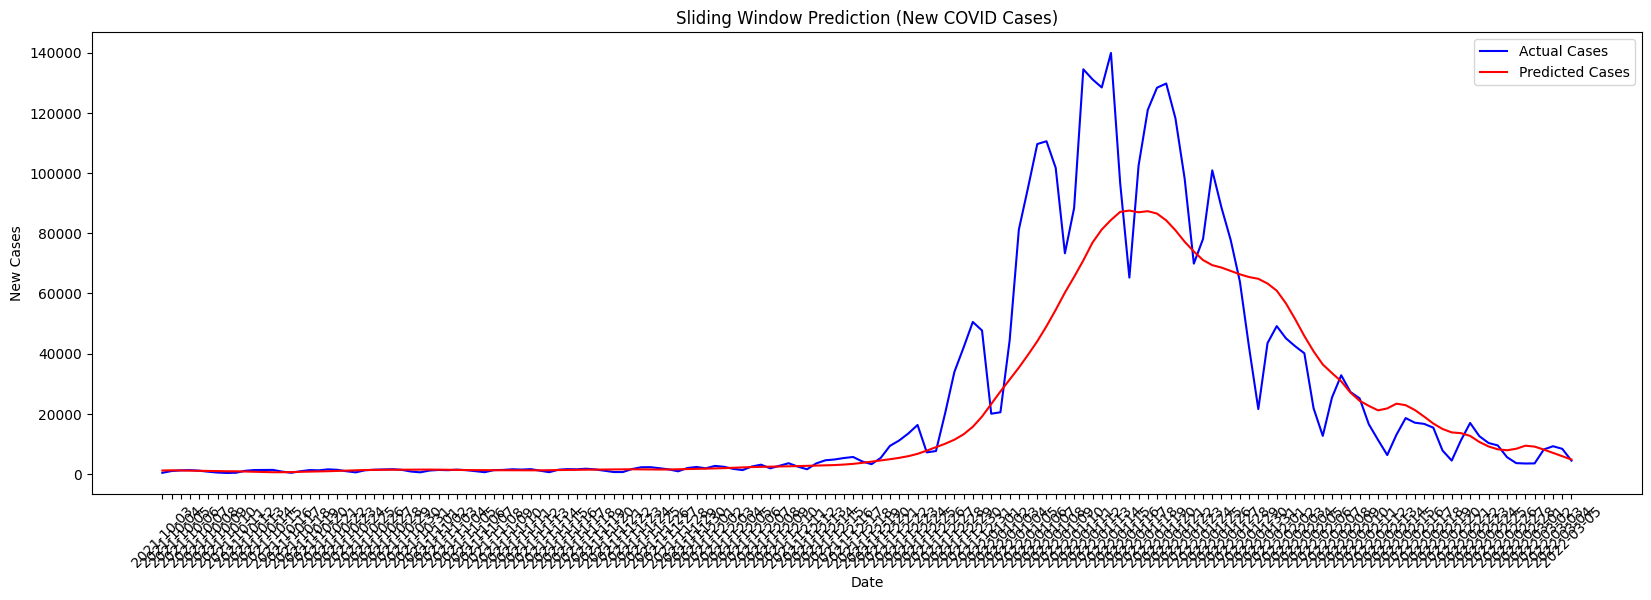

MAE: 8657.442212389662
MAE / Mean: 0.3627904238580083
RMSE: 17385.457508753716
Region: MEX
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


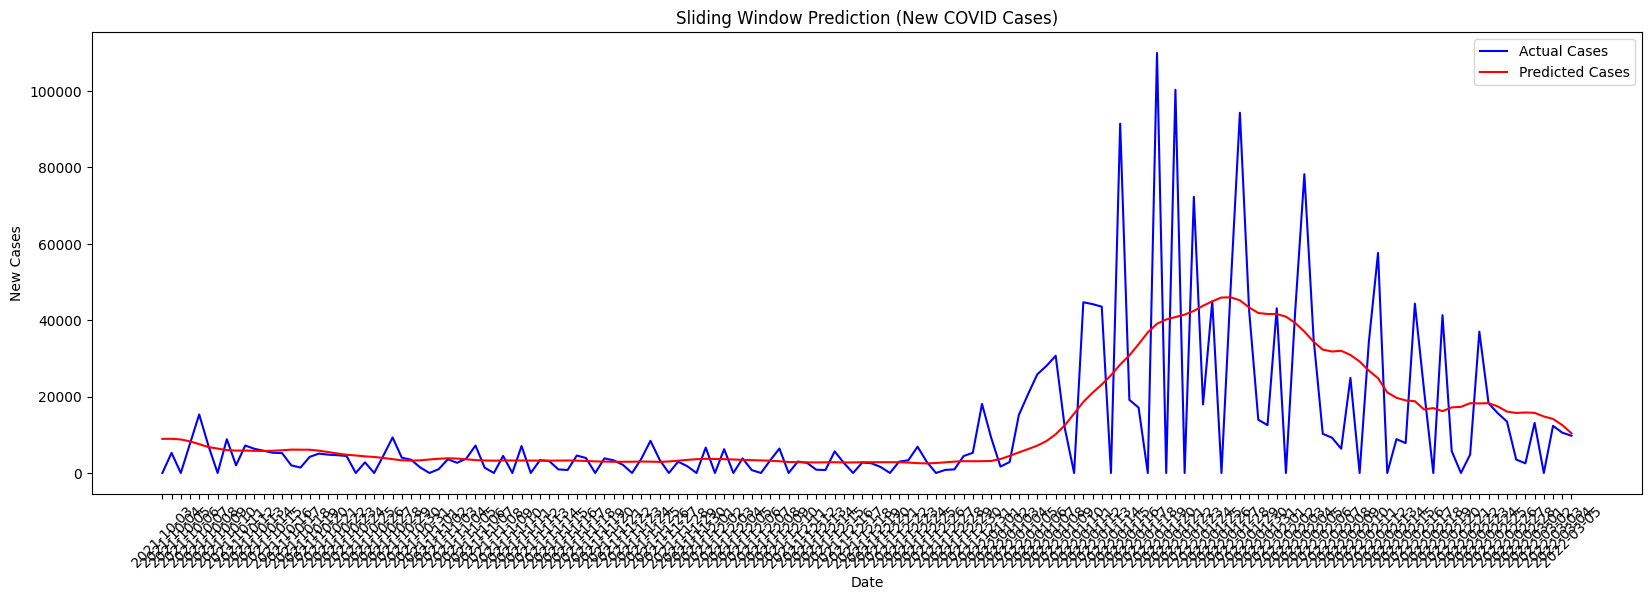

MAE: 9249.566528320312
MAE / Mean: 0.7595308366168757
RMSE: 16356.137669767508
Region: THA
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


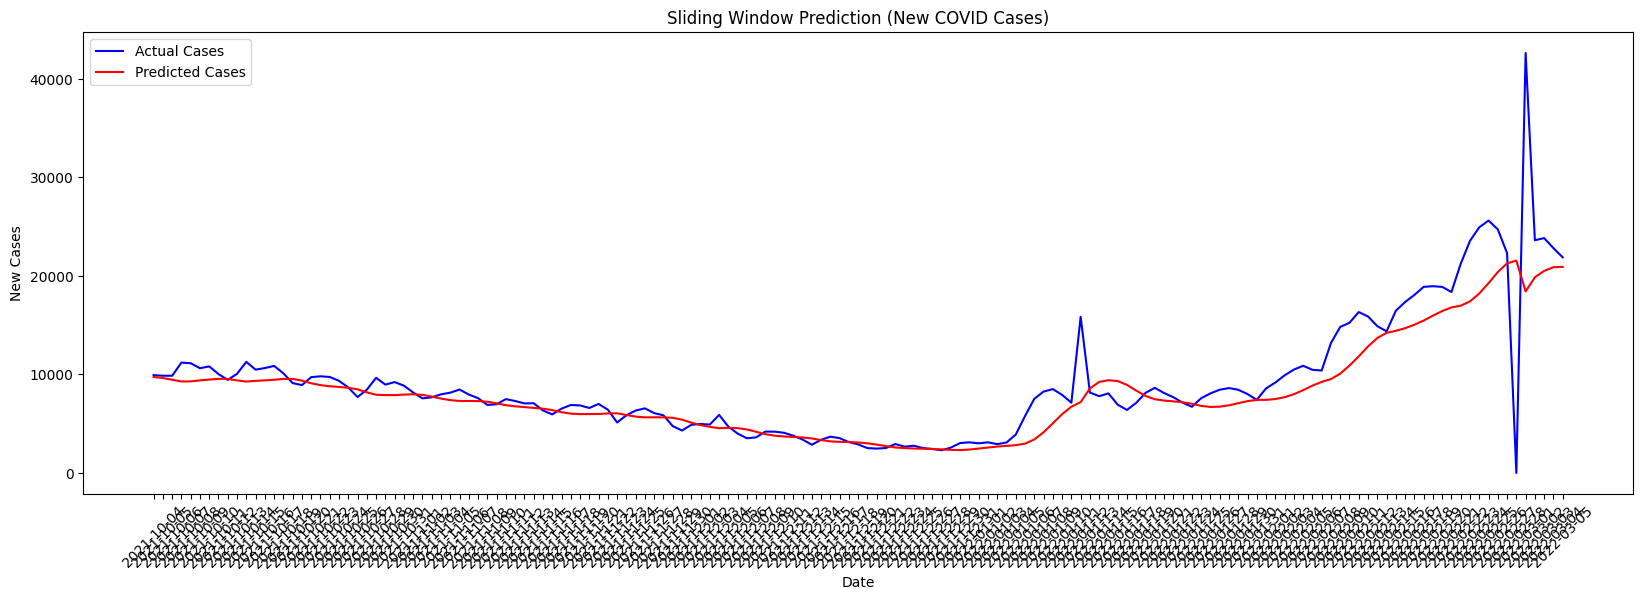

MAE: 1550.9947198606005
MAE / Mean: 0.17081156853574297
RMSE: 3249.908086906733
Region: TWN
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


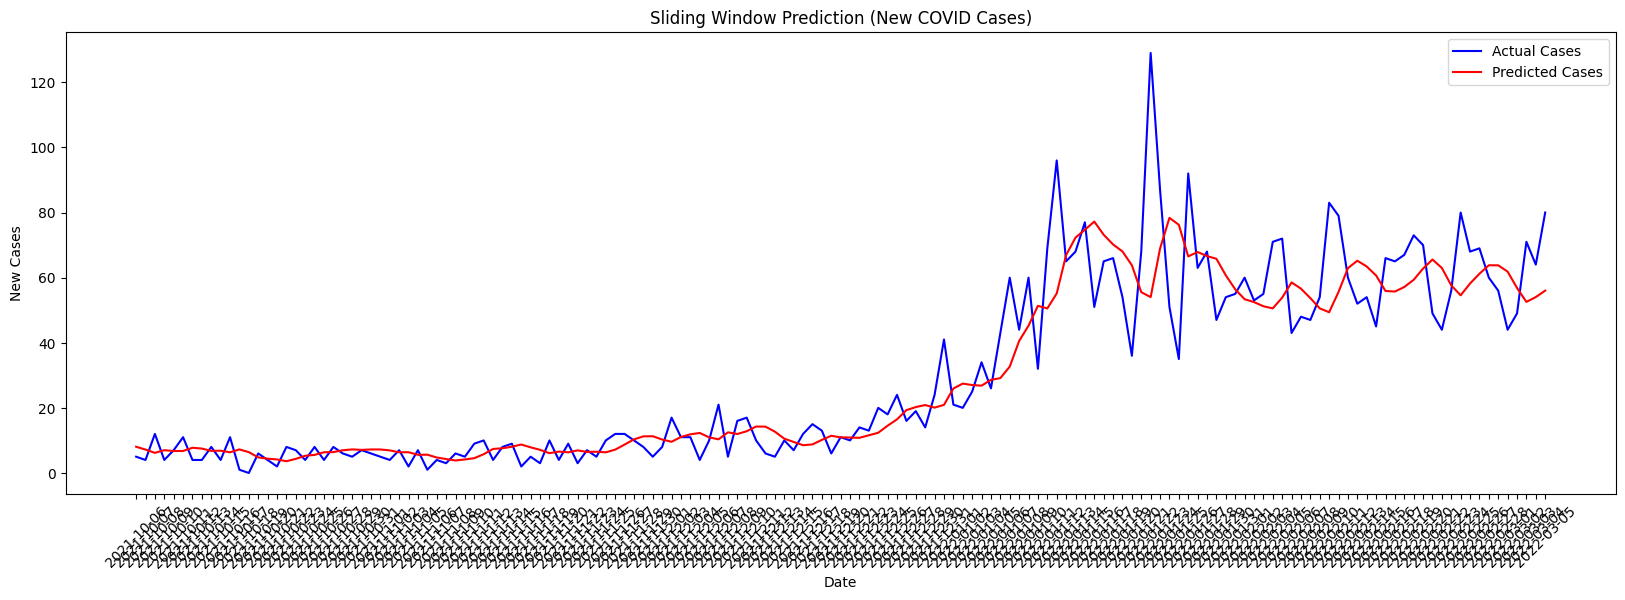

MAE: 7.877058284961625
MAE / Mean: 0.26227911819828126
RMSE: 12.527282742846964
Region: CHN
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


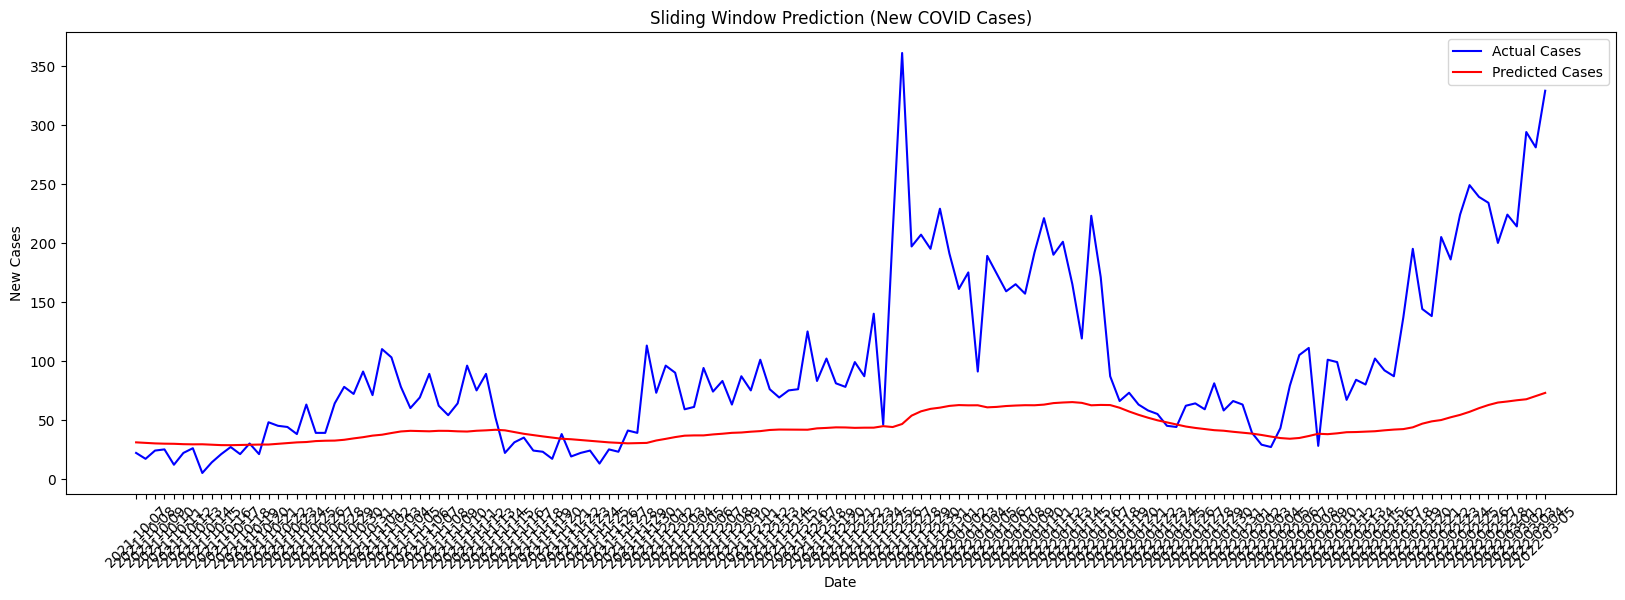

MAE: 57.465734532674155
MAE / Mean: 0.5931232491502871
RMSE: 82.62961499836206
Region: OWID_ASI
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


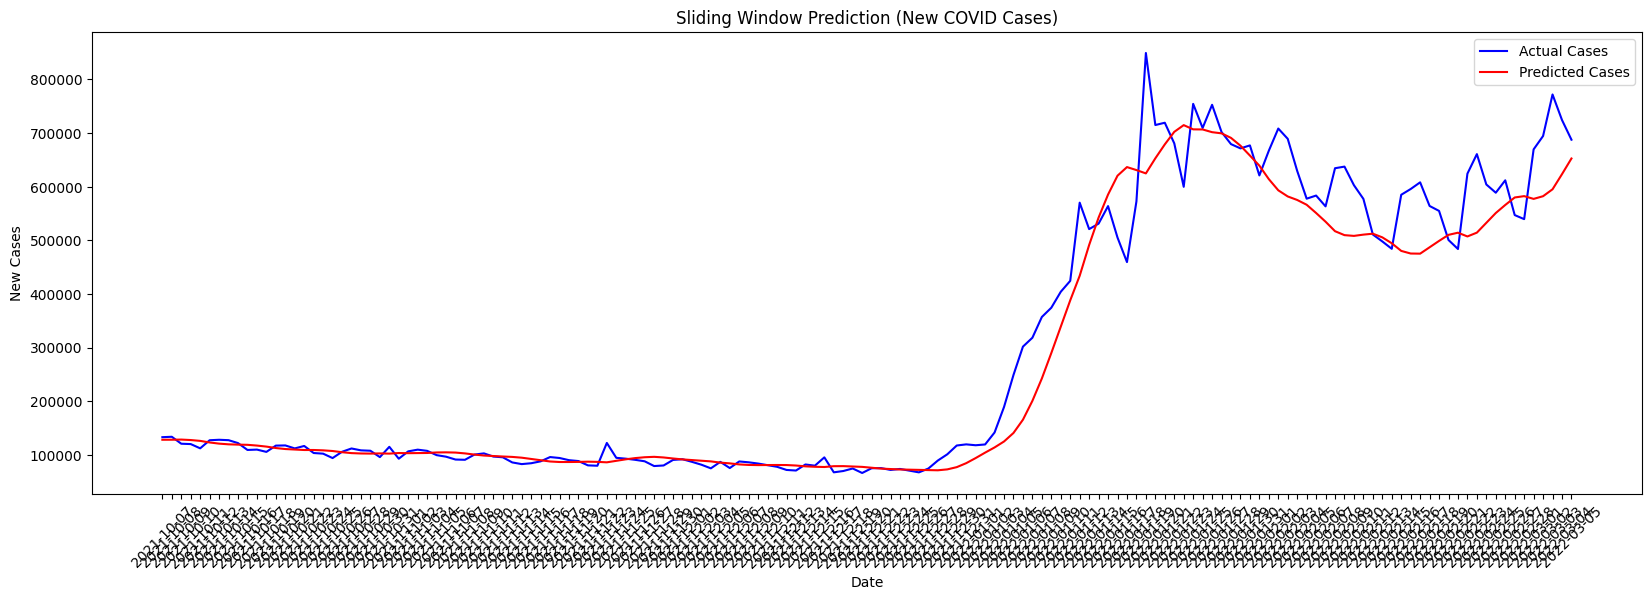

MAE: 33330.17864583333
MAE / Mean: 0.11357571572422194
RMSE: 55912.00979986153
Region: OWID_NAM
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


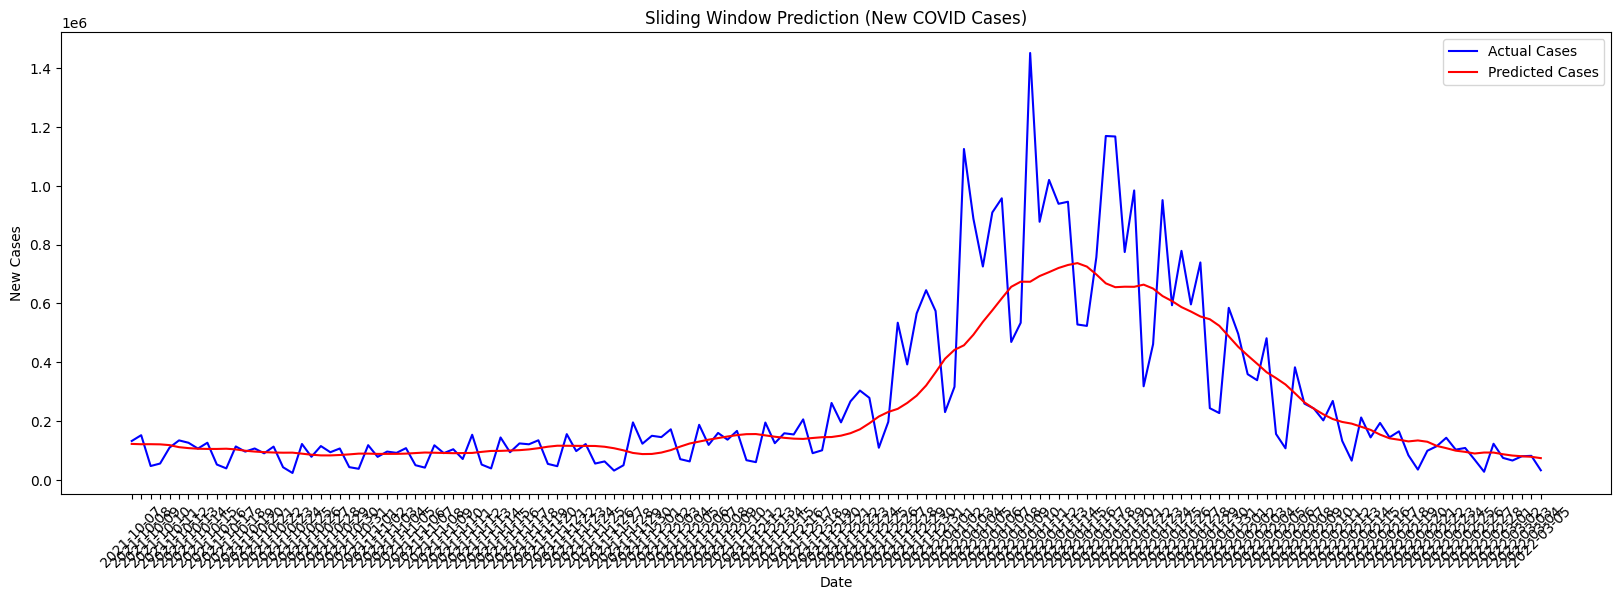

MAE: 95280.15046875
MAE / Mean: 0.35463744979234185
RMSE: 157999.6038742435
Region: MAC
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


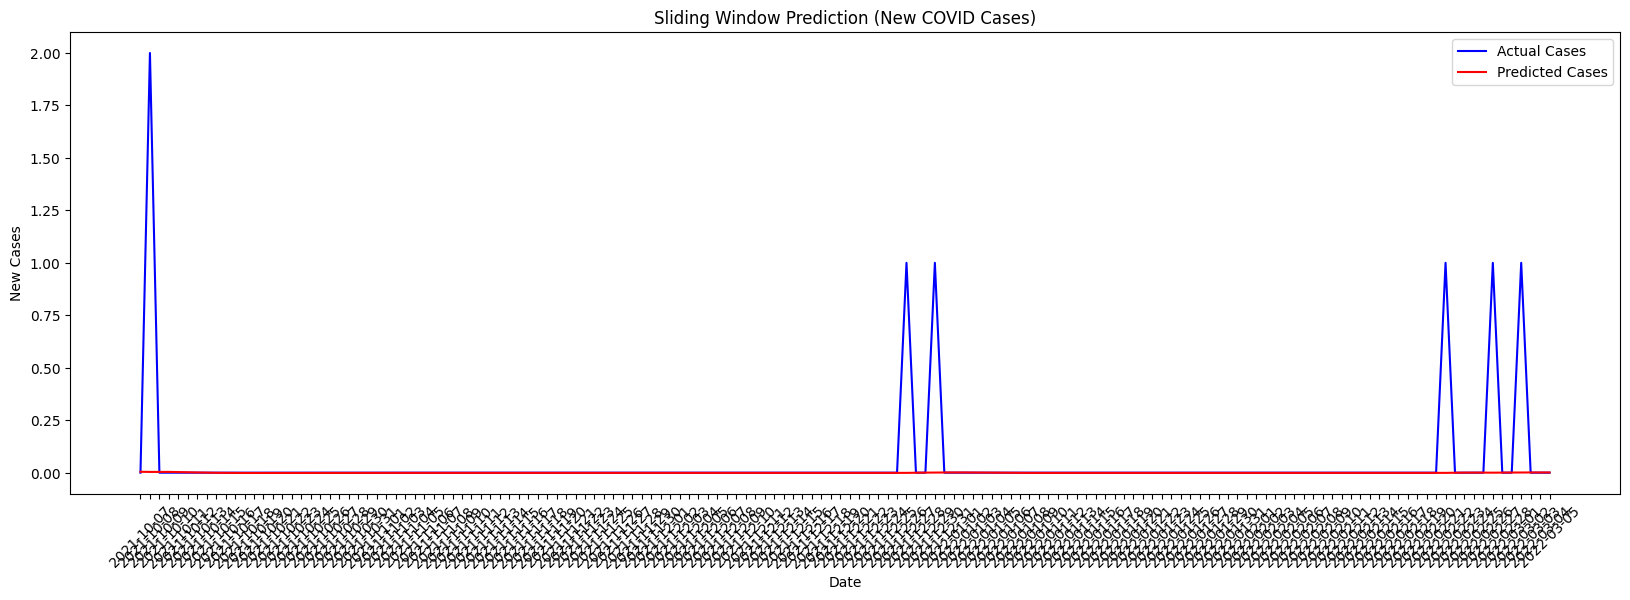

MAE: 0.04755797094131897
MAE / Mean: 1.019099377313978
RMSE: 0.24477013941508227
Region: KOR
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


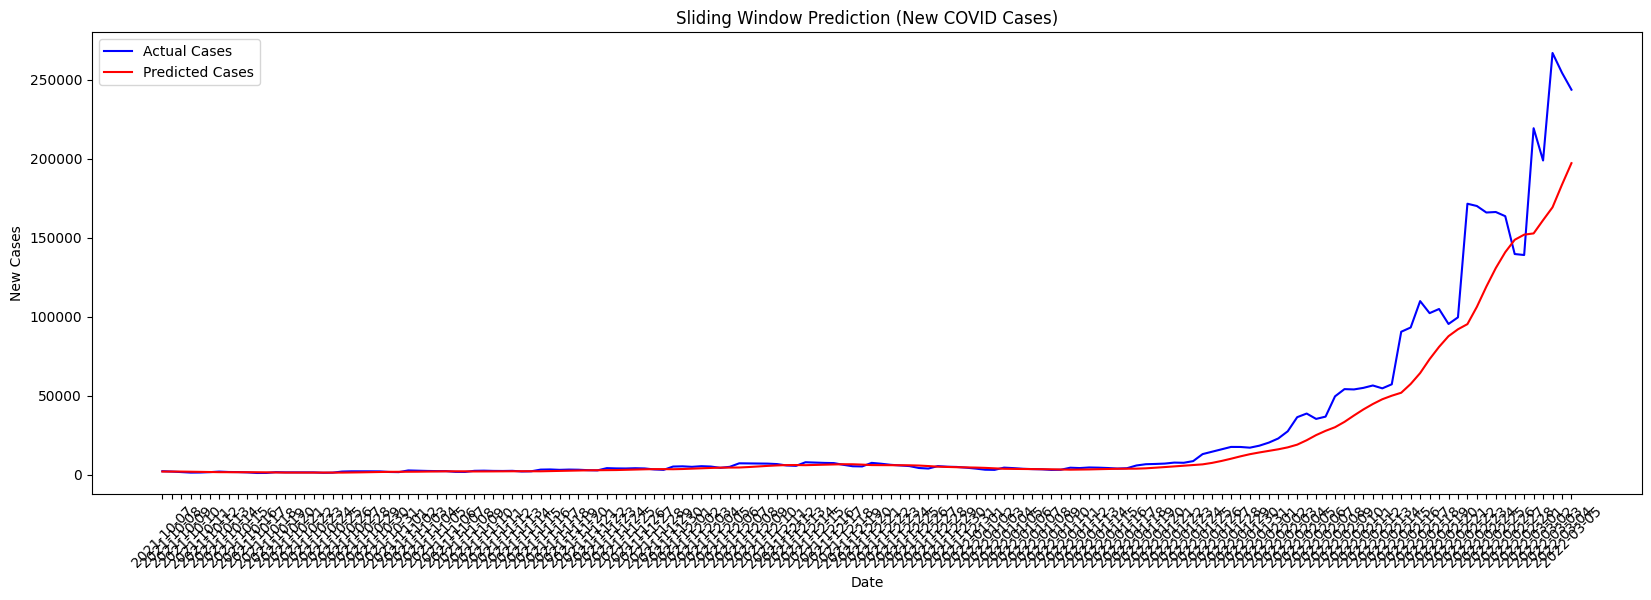

MAE: 7131.6479191080725
MAE / Mean: 0.2589898432296187
RMSE: 17492.299404901496
Region: OWID_UMC
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


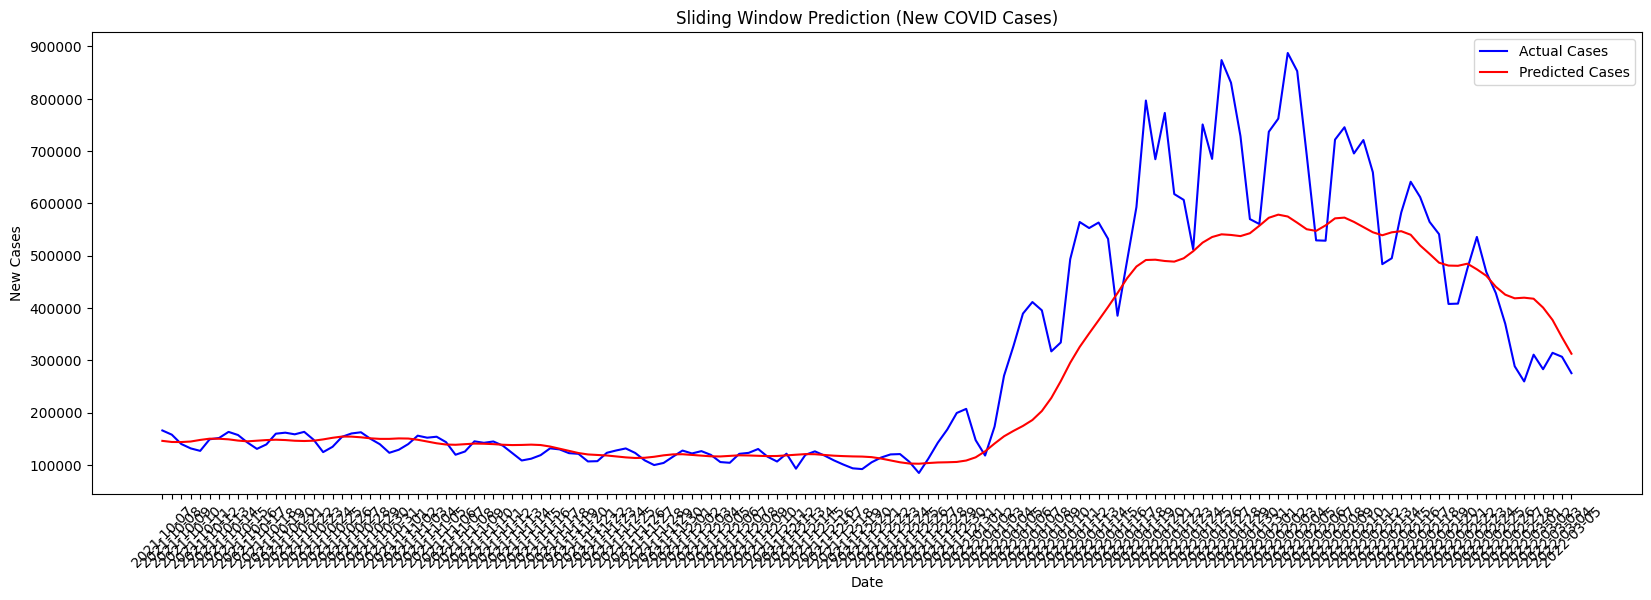

MAE: 59674.43171875
MAE / Mean: 0.1994614963573488
RMSE: 99169.77940410182


In [44]:
for region in regions:
    print("=" * 50)
    print(f"Region: {region}")
    
    lstm_sliding_window_prediction(region)

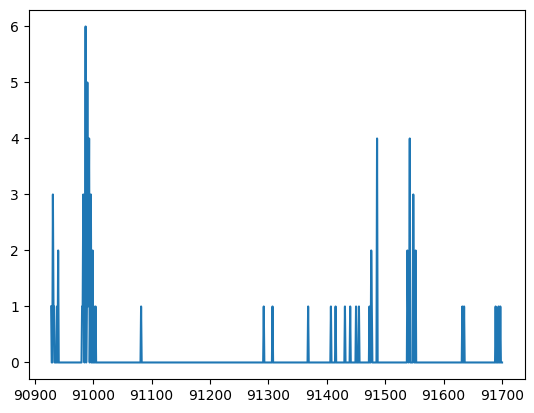

In [49]:
data = pd.read_csv(r"data\owid-covid-data.csv")
region_data = data[data['iso_code'] == "MAC"]
from matplotlib.pyplot import plot
plot(region_data["new_cases"])

In [51]:
region_data["new_cases"].describe()

count    773.000000
mean       0.104787
std        0.504529
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: new_cases, dtype: float64